In [628]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 


In [629]:
# download data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

full_data = [train, test]

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [630]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


特征工程 Feature Engineering
----------

这里对一些分类变量进行分析

**1.Pclass(Ticket class)**  
从train.info中可以看到Pclass没有缺失值且已经数字化，查看在训练集上对'Survived'的影响情况

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


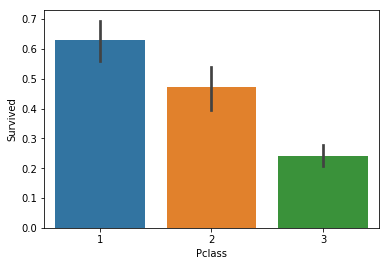

In [631]:
print( train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean() )
sns.barplot(x='Pclass', y='Survived', data=train) #visulizing 

**2.Sex**

In [632]:
#2.Sex
print( train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean() )

      Sex  Survived
0  female  0.742038
1    male  0.188908


**3.Embarked**  
Embarked有一些缺失值，这里简单的讲缺失值用出现最多的值代替

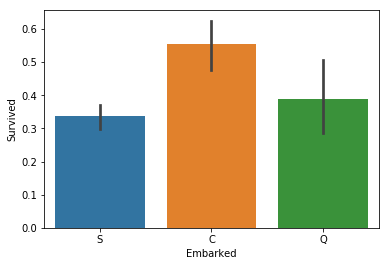

In [633]:
#visualizing data
sns.barplot(x='Embarked', y='Survived', data=train)

In [634]:
#统计Embarked取值（S，C，Q）的频率,
train.loc[:,'Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [635]:
#S 取值最多，将Embarked的缺失值用'S'代替
for data in full_data:
    data['Embarked'] = data['Embarked'].fillna('S')
    
#sns.barplot(x='Embarked', y='Survived', data=train);
print(train[['Embarked','Survived']].groupby('Embarked', as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


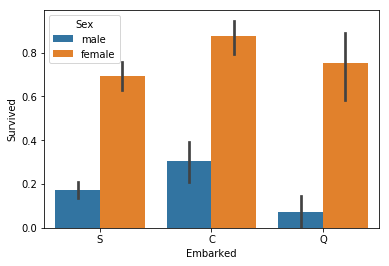

In [636]:
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=train)

**4.Age**     
age有不少的缺失，对于那些缺失值采用的办法是：在（mean-std）和（mean+std）之间随机产生


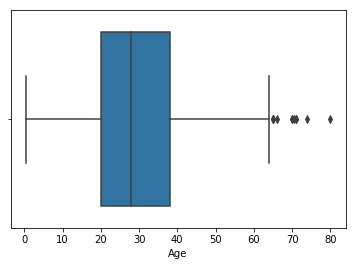

In [637]:
sns.boxplot(train['Age']) # 通过箱形图查看年龄分布

In [638]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [639]:
#对于那些缺失值采用的办法是：在（mean-std）和（mean+std）之间随机产生
for data in full_data:
    age_avg = data['Age'].mean()
    age_std = data['Age'].std()
    age_null_count = data['Age'].isnull().sum()
    
    #产生随机数列表
    age_null_random_list = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    data['Age'][np.isnan(data['Age'])] = age_null_random_list
    data['Age'] = data['Age'].astype(int)

In [640]:
#将年龄分阶段
bins = (0, 10, 18, 40, 60, 100)
train['Categories_Age'] = pd.cut(train['Age'], bins)

print(train[['Categories_Age','Survived']].groupby(['Categories_Age'], as_index=False).mean())

  Categories_Age  Survived
0        (0, 10]  0.543860
1       (10, 18]  0.350000
2       (18, 40]  0.372760
3       (40, 60]  0.380952
4      (60, 100]  0.227273


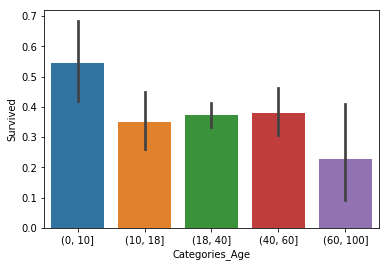

In [641]:
sns.barplot(x='Categories_Age', y='Survived', data=train)

**5.Name**    
观察name这一列可以看到有title这个特征，尝试分析title对SUrvived的影响

In [642]:
import re as re

# 获取title
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # if the title exists,then extract and return it
    if title_search:
        return title_search.group(1)

for data in full_data:
    data['Title'] = data['Name'].apply(get_title)

In [643]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Sir           1
Countess      1
Mme           1
Lady          1
Ms            1
Jonkheer      1
Capt          1
Don           1
Name: Title, dtype: int64

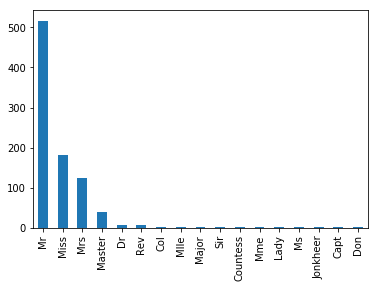

In [644]:
train['Title'].value_counts().plot(kind='bar')

In [645]:
#使用交叉表crosstab,可以按照指定的行和列统计分组频数
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [646]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


**6.Fare**  
Fare也存在一些缺失值，对于这些缺失值这里使用“中值”来填充，同时将fare分为4个范围

In [647]:
for data in full_data:
    data['Fare'] = data['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare','Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


**注意**，这里使用的是qcut,其与cut的区别是：cut将根据值本身来选择箱子均匀间隔，qcut是根据这些值的频率来选择箱子的均匀间隔   
（可以看到，随着票价的提高生存率也逐步提高，**扎心**。。。。。。）

**7.SibSp and Parch**   
根据SibSp和Parch变量，可以生成一个新的特征--FamilySize,观察家庭成员人数对生存率的影响

In [648]:
for data in full_data:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [649]:
#再观察是否是独自一个人对survived的影响
for data in full_data:
    data['IsAlone'] = 0
    data.loc[data['FamilySize']==1, 'IsAlone'] = 1
    
train[['IsAlone','Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


**8.Cabin**  



In [650]:
#Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

Data Cleaning
-----------
在上面对变量做了简要分析之后，开始对数据进行清洗，去除认为对模型不必要的特征，同时将那些模型需要却不是数字化的特征映射为numerical values:比如Sex中的“female”、“male”分别映射为“0”，“1”

In [651]:
for data in full_data:
    # Mapping Sex
    data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} )
    
    #Mapping titles
    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)
    
    #Mapping Embarked
    data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2})
    
    #Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare'] = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)
    
    #Mapping Age
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4




In [652]:
train.loc[:5, 'Sex']

0    1
1    0
2    0
3    0
4    1
5    1
Name: Sex, dtype: int64

In [653]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null int64
Age                891 non-null int32
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null int32
Cabin              204 non-null object
Embarked           891 non-null int64
Categories_Age     884 non-null category
Title              891 non-null int64
CategoricalFare    891 non-null category
FamilySize         891 non-null int64
IsAlone            891 non-null int64
Has_Cabin          891 non-null int64
dtypes: category(2), int32(2), int64(11), object(3)
memory usage: 106.4+ KB


In [654]:
# Feature Selection
# 将一些特征舍弃（drop）
drop_features = ['PassengerId','Name','Ticket','Cabin','SibSp','Parch','FamilySize']

train = train.drop(drop_features, axis = 1)
train = train.drop(['Categories_Age', 'CategoricalFare'], axis = 1) # 这两个特征只是在train中存在

test = test.drop(drop_features, axis = 1)

In [655]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Has_Cabin
0,0,3,1,1,0,0,1,0,0
1,1,1,0,2,3,1,3,0,1
2,1,3,0,1,1,0,2,1,0
3,1,1,0,2,3,0,3,0,1
4,0,3,1,2,1,0,1,1,0


In [656]:
train.values

array([[0, 3, 1, ..., 1, 0, 0],
       [1, 1, 0, ..., 3, 0, 1],
       [1, 3, 0, ..., 2, 1, 0],
       ..., 
       [0, 3, 0, ..., 2, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 3, 1, ..., 1, 1, 0]], dtype=int64)

**截至目前，我们已经对特征变量对目标变量的影响做了简要分析，舍弃了一些认为不重要的特征变量，同时将一些非数字化的特征值映射为数值化的量以方便模型的使用**


Visulization
------
通过**Correlation Heatmap**来观察各个特征变量和目标变量的关联程度

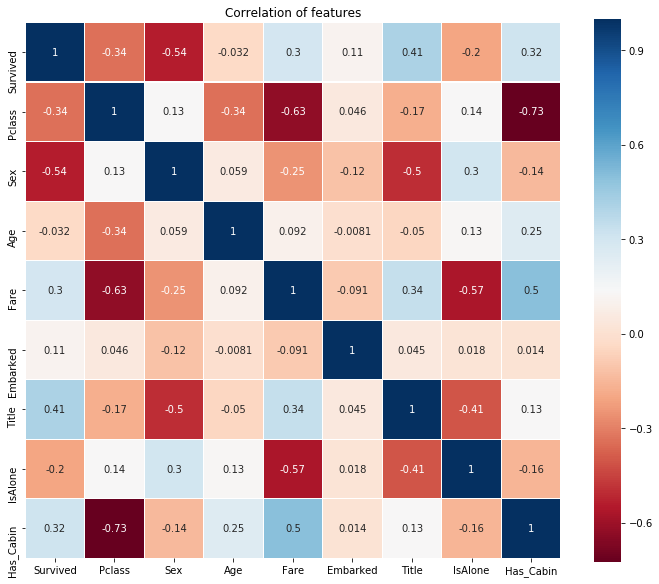

In [657]:
f,ax = plt.subplots(figsize=(12,10))
ax.set_title('Correlation of features')
corrmat = train.corr()
colormap = plt.cm.RdBu
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap=colormap, annot=True)

从皮尔逊相关图（Pearson Correlation plot）可以看到没有特征与另一个特征强相关，这意味着预处理后的训练集中没有太多冗余的数据——每个特征都带有一些独特的信息，这对训练模型来说是一件好事。  


Ensembling & Stacking models
----------------
在特征工程和数据规格化之后，开始进入模型训练阶段。  

不同的算法模型，相当于从不同的数据空间、数据结构角度观察数据集中数据，然后根据观测的结果结合自己的算法原理，建立一个模型。因为是不同角度建立起来的模型，如果把他们结合起来，“取长补短”，是不是结果会被优化？**Stacking就是一种模型集成的策略，对不同角度得到的模型“取长补短”，优化结果。**

In [658]:
# 载入必要的库
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV

In [659]:
# 创建一个名为SklearnHelper类，供Sklearn中的classifier通用（train,predict,fit）,可以减少代码的冗余度

#some useful parameters whcih will come in handy later on
ntrain = train.shape[0]  # 891
ntest = test.shape[0]    # 418
SEED = 0 # 为了随机结果可重现设置种子 (for reproducibility)
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED) # 划分交叉验证子集（NFOLDS折交叉验证） sklearn.cross_validation.KFold(n=891, n_folds=5, shuffle=False, random_state=0)


# Write a Class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) 
# common to all the Sklearn classifiers
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        return (self.clf.fit(x,y).feature_importances_)

    

Out-of-Fold Prediction
-----
Stacking有种交叉验证的既视感，每一个基模型对train数据集生成一列新的特征表达、同样的对test数据集生成一列新的特征表达，即假设使用了N个基模型，最后对整个的train数据集生成N列新的特征表达，同样test数据集也有N列对应的新的特征表达。
这时候将已经包含了基模型预测输出结果（新的特征表达）的train、test数据集作为第二层模型的训练、测试集。（当然stacking可以有很多层，但是要考虑时间复杂度，且效果不一定层数多就一定好）

In [660]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    #train数据集上N折交叉验证，将train数据集划分大小近似的N份，其中一份作为test用
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    
    oof_test[:] = oof_test_skf.mean(axis=0) # 每N-1份数据子集训练出的模型在整个test上的预测取平均
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1) # 转换成1列(生成的是新的特征表达列)

Generating Base First-Level Models
--------------------
先生成第一层的基模型，这里使用了直接从Sklearn中调用的5个学习模型：
1. Random Forest Classifier
2. Extra Trees Classifier
4. AdaBoost Classifier
4. Gradient Boosting Classifier
5. Support Vector Machine

In [661]:
# 设定对应模型的参数
# Random Forest Parameters
rf_params = {
    'n_jobs':-1, #n_jobs指定处理器数目，-1没有限制
    'n_estimators':500,
    'max_depth':6,
    'min_samples_leaf':2, # 叶子节点最小样本数
    'max_features':'sqrt', # amx_features:允许单个决策树使用特征的最大数量,'sqrt':总特征数的平方根
}

# Extra Trees Parameters
et_params = {
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2
}

# AdaBoost parameters
ada_params = {
    'n_estimators':500,
    'learning_rate':0.03
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators':500,
    'max_depth':5,
    'min_samples_leaf':2
}

# Support Vector Classifier Parameters
svc_params = {
    'kernel':'linear',
    'C':0.05
}

In [662]:
# 借助之前定义的SklearnHelper类创建对应的学习模型
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)

ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [663]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel() # ravel()将多维数组降为一维
x_train = train.drop(['Survived'], axis=1)
x_train = x_train.values # Creates an array of the train data
x_test = test.values # Creates an array of the train data

First Level Predictions
---------------------
利用之前定义的get_oof函数输出每个基模型预测的结果——**每个基模型分别在原先的训练集和测试集上生成一列新的特征**

In [664]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest Classifier

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees Classifier

ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost Classifier

gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boosting Classifier

svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("-------------Training is completed-------------")

-------------Training is completed-------------


In [665]:
rf_feature_imp = rf.feature_importances(x_train,y_train)
et_feature_imp = et.feature_importances(x_train,y_train)
ada_feature_imp = ada.feature_importances(x_train,y_train)
gb_feature_imp = gb.feature_importances(x_train,y_train)

In [671]:
print(rf_feature_imp)
print(et_feature_imp)
print(ada_feature_imp)
print(gb_feature_imp)

[ 0.14681105  0.2895847   0.04632412  0.07909942  0.03753065  0.29741728
  0.02508672  0.07814607]
[ 0.1410578   0.39649424  0.04113541  0.07160203  0.03791436  0.184556
  0.03289361  0.09434655]
[ 0.202  0.068  0.142  0.01   0.086  0.348  0.07   0.074]
[ 0.14765911  0.05760344  0.16448555  0.22842165  0.07638474  0.12831832
  0.14898016  0.04814704]


In [672]:
# 创建一个DataFrame,包含每个基模型特征重要性信息
cols = train.drop(['Survived'],axis=1).columns.values # array

feature_dataFrame = pd.DataFrame({
    'features':cols,
    'Random Forest feature importances':rf_feature_imp,
    'Extra Trees feature importances':et_feature_imp,
    'AdaBoost feature importances':ada_feature_imp,
    'Gradient Boosting feature importances':gb_feature_imp
})

# output dataframe
feature_dataFrame

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boosting feature importances,Random Forest feature importances,features
0,0.202,0.141058,0.147659,0.146811,Pclass
1,0.068,0.396494,0.057603,0.289585,Sex
2,0.142,0.041135,0.164486,0.046324,Age
3,0.010,0.071602,0.228422,0.079099,Fare
4,0.086,0.037914,0.076385,0.037531,Embarked
5,0.348,0.184556,0.128318,0.297417,Title
6,0.070,0.032894,0.148980,0.025087,IsAlone
7,0.074,0.094347,0.048147,0.078146,Has_Cabin


可以看出在不同基模型中每个特征的重要程度

In [674]:
feature_dataFrame['Random Forest feature importances'].values

array([ 0.14681105,  0.2895847 ,  0.04632412,  0.07909942,  0.03753065,
        0.29741728,  0.02508672,  0.07814607])

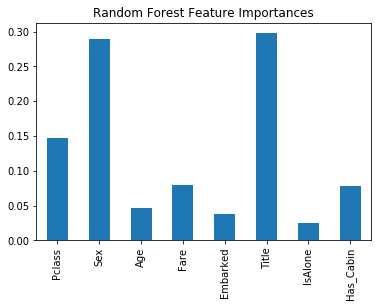

In [685]:
rf_feat_imp_hist = pd.Series(feature_dataFrame['Random Forest feature importances'].values, cols)
rf_feat_imp_hist.plot(kind='bar', title='Random Forest Feature Importances')

现在在原先的dataframe中增加一列--表示每个特征在各个模型中importances的平均值

In [690]:
# Create the new column containing the average of values

feature_dataFrame['mean'] = feature_dataFrame.mean(axis=1) # axis=1 compute the mean row-wise
feature_dataFrame

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boosting feature importances,Random Forest feature importances,features,mean
0,0.202,0.141058,0.147659,0.146811,Pclass,0.159382
1,0.068,0.396494,0.057603,0.289585,Sex,0.202921
2,0.142,0.041135,0.164486,0.046324,Age,0.098486
3,0.010,0.071602,0.228422,0.079099,Fare,0.097281
4,0.086,0.037914,0.076385,0.037531,Embarked,0.059457
5,0.348,0.184556,0.128318,0.297417,Title,0.239573
6,0.070,0.032894,0.148980,0.025087,IsAlone,0.069240
7,0.074,0.094347,0.048147,0.078146,Has_Cabin,0.073660


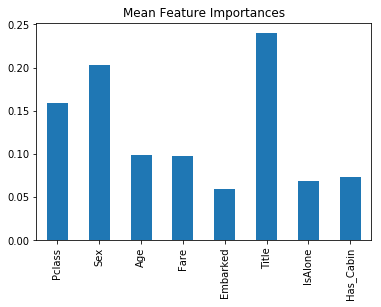

In [717]:
mean_feat_impotrances = pd.Series(feature_dataFrame['mean'].values, cols)
mean_feat_impotrances.plot(kind='bar', title='Mean Feature Importances')

Second-Level Predictions from the First-Level Output
==================
第一层各个模型的输出作为新的特征,第二层训练将加入这些基于基模型训练出来的新的特征

In [729]:
# 基模型在train set训练出的结果保存在一个dataFrame中
base_predictions_train = pd.DataFrame({'RandomForest':rf_oof_train.ravel(), # 将多维降为一维891x1 -> 1x891
                                      'ExtraTrees':et_oof_train.ravel(),
                                      'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel()})

base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


很多Kaggle比赛的获奖者都会强调stacking中各个基模型的不相关性，一般认为各个基模型越不相关最后的效果可能会越好（我的理解是，各个基模型不相关度小，说明是从数据空间的不同角度观测数据，这样才能真正起到stacking不同模型提升效果的目的)。  
现在看一下各个基模型之间的相关程度：


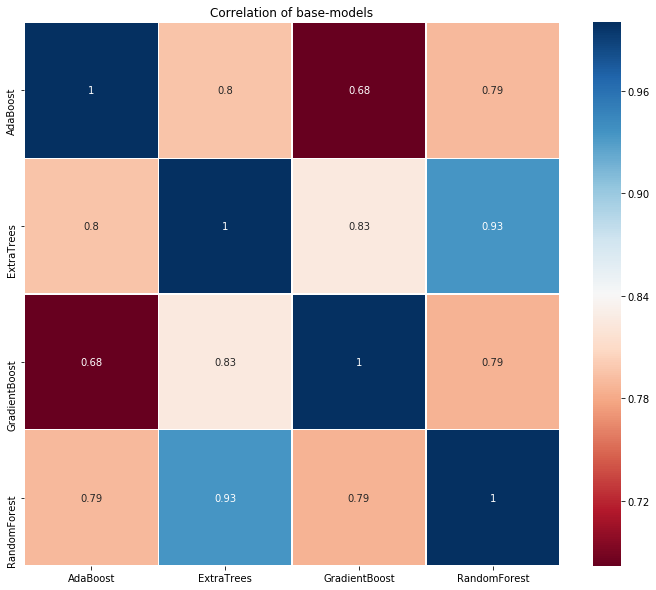

In [732]:
f,ax = plt.subplots(figsize=(12,10))
ax.set_title('Correlation of base-models')
corrmat = base_predictions_train.corr()
colormap = plt.cm.RdBu
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=False, cmap=colormap, annot=True)

In [735]:
# 使用numpy.concatenate((a1,a2,...), axis=0)函数，能够一次完成多个数组的拼接
# axis=1表示对应行的数组进行拼接
x_train = np.concatenate((et_oof_train,rf_oof_train,ada_oof_train,gb_oof_train,svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test,rf_oof_test,ada_oof_test,gb_oof_test,svc_oof_test), axis=1)
x_test

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.8,  1. ,  1. ,  0.2,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.8,  0. ,  0.2,  1. ,  0.2]])

#### 第二层模型使用XGBoost,并给出最后的预测结果

In [737]:
import xgboost as xgb
xgb = xgb.XGBClassifier(learning_rate=0.03,
                       n_estimators=500,
                       max_depth=4,
                       min_child_weight=2,
                       gamma=0,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       objective='binary:logistic')

xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)

In [745]:
# 保存结果
original_test = pd.read_csv('test.csv')
stackingResult = pd.DataFrame({'PassengerId':original_test.PassengerId, 'Survived':predictions})
stackingResult.to_csv('stackingResult.csv', index=False)
stackingResult.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
